In [27]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTENC, RandomOverSampler
import xgboost as xgb

from utils import SOSEncoder, TargetEncoder

import warnings
warnings.filterwarnings('ignore')

## Configuration

In [2]:
DIR = 'D:\\PPrograms\\Python\\Kaggle\\Predicting Loan Pay\\'
TARGET = 'loan_paid_back'
SEED = 42

In [3]:
train = pd.read_csv(os.path.join(DIR, 'data\\train.csv'), index_col='id')
test = pd.read_csv(os.path.join(DIR, 'data\\test.csv'), index_col='id')

In [4]:
nvp = np.sum(train[TARGET]==0)/np.sum(train[TARGET]==1)
print(f'The ratio of negative sample vs positive sample is {nvp}.')

The ratio of negative sample vs positive sample is 0.25184723094496453.


In [5]:
NUM = [col for col in test.columns if train[col].dtypes in ('float64', 'int64')]
CAT = [col for col in test.columns if train[col].dtypes in ('object',)]
COL = NUM + CAT
print(f'There are {test.shape[1]} cols, in which {len(NUM)} are numerical and {len(CAT)} are categorical.')

There are 11 cols, in which 5 are numerical and 6 are categorical.


In [6]:
train, valid = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[TARGET])

## Feature Engineering
### Frequency

In [7]:
FREQ = []

sos = SOSEncoder(20)
def generate_frequency_feature(df, *df_other):
    train = pd.DataFrame(index=df.index)
    other = [pd.DataFrame(index=_.index) for _ in df_other]

    for col in COL:
        # --- Frequency Features ---
        # count the number of occurrences of each unique values
        freq= df[col].value_counts()
        col_name = f'{col}_freq'
        train[col_name] = df[col].map(freq)
        for i in range(len(other)):
            other[i][col_name] = df_other[i][col].map(freq).fillna(freq.mean())
        FREQ.append(col_name)
        # --- Bin Features ---
        # split the numerical col into bins
        if col in NUM:
            for q in [5, 10, 15]:
                train_bins, bins = pd.cut(df[col], bins=q, labels=False, retbins=True, duplicates="drop")
                col_name = f'{col}_bins{q}'
                train[col_name] = train_bins
                for i in range(len(other)):
                    other[i][col_name] = pd.cut(df_other[i][col], bins=bins, labels=False, duplicates="drop", include_lowest=True)

                FREQ.append(col_name)
    # --- Weighted Bins Features ---
    # split the numerical col into bins while label there weight
    res = sos.fit_transform(df[NUM])
    train = train.join(res)
    for i in range(len(other)):
        res = sos.transform(df_other[i][NUM])
        other[i] = other[i].join(res)

    FREQ.extend(sos.res_columns)

    # concatenate all features at once
    df = pd.concat([df, train], axis=1)
    for i in range(len(other)):
        other[i] = pd.concat([df_other[i], other[i]], axis=1)
    return df, *other

train, test, valid = generate_frequency_feature(train, *[test, valid])
print(f'{len(FREQ)} Frequency features created.')

136 Frequency features created.


### Subgrade

In [8]:
SUBGRADE = []

def generate_subgrade_feature(df, *df_other):
    grade_map = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
    }

    df['ordered_grade'] = df['grade_subgrade'].str[0].map(grade_map)
    df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
    for data in df_other:
        data['ordered_grade'] = data['grade_subgrade'].str[0].map(grade_map)
        data['subgrade'] = data['grade_subgrade'].str[1:].astype(int)
    SUBGRADE.append('ordered_grade')
    SUBGRADE.append('subgrade')

    return df, *df_other

train, test, valid = generate_subgrade_feature(train, *[test, valid])
print(f'{len(SUBGRADE)} Subgrade features created.')

3 Subgrade features created.


### OrdCategory

In [9]:
ORDCATE = []
def generate_ordcategory_feature(df, *df_other):
    edu_map = {
        "Other": 0,
        "High School": 1,
        "Bachelor's": 2,
        "Master's": 3,
        "PhD": 4,
    }
    emp_map = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 4,
    }
    for data in [df, *df_other]:
        data['ordered_edu_level'] = data['education_level'].map(edu_map)
        data['ordered_employment_status'] = data['employment_status'].map(emp_map)
    ORDCATE.append('ordered_edu_level')
    ORDCATE.append('ordered_employment_status')

    return df, *df_other

train, test, valid = generate_ordcategory_feature(train, test, valid)
print(f'{len(ORDCATE)} Ordcategory features created.')

2 Ordcategory features created.


### Round

In [10]:
ROUND = []

def generate_round_feature(df, *df_other):
    rounding_levels = {
        '1r': 0,
        '10r': -1,
        '100r': -2
    }
    for col in ['annual_income', 'loan_amount']:
        for suffix, level in rounding_levels.items():
            col_name = f'{col}_{suffix}'
            for data in [df, *df_other]:
                data[col_name] = data[col].round(level).astype(int)

            ROUND.append(col_name)
    return df, *df_other

train, test, valid = generate_round_feature(train, test, valid)
print(f'{len(ROUND)} Round features created.')

6 Round features created.


### Target

In [11]:
TAR = []

tar = TargetEncoder(cols_to_encode=COL, aggs=['mean', 'count'], drop_original=True)
def generate_target_feature(df, *df_other):
    other = list(df_other)

    df_tar = tar.fit_transform(df[COL], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(tar.transform(other[i][COL]))
    TAR.extend(df_tar.columns)

    return df, *other

train, test, valid = generate_target_feature(train, test, valid)
print(f'{len(TAR)} Target features created.')

22 Target features created.


In [12]:
for col in CAT:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    valid[col] = valid[col].astype('category')

In [13]:
FEATURES = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE
print(len(FEATURES), 'Features.')

180 Features.


## ROS Resample

In [14]:
# apply ROS to train data
print(f'Before SMOTE the category rate: 0 = {np.sum(train[TARGET]==0)} 1 = {np.sum(train[TARGET]==1)}.')

ros = RandomOverSampler(random_state=SEED, sampling_strategy=0.5)
train, _ = ros.fit_resample(train, train[TARGET])

print(f'After SMOTE the category rate: 0 = {np.sum(train[TARGET]==0)} 1 = {np.sum(train[TARGET]==1)}.')

Before SMOTE the category rate: 0 = 95600 1 = 379595.
After SMOTE the category rate: 0 = 189797 1 = 379595.


## Feature Select

In [15]:
cv = 5
base_feas_select = []

In [16]:
def xgg_feature_test(X, y, cv=5, seed=42, **kwargs):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    params = {
        'booster':'gbtree',
        'eval_metric': 'auc',
        "objective": "binary:logistic",
        "tree_method": "hist",
        "device": "cuda",
        'seed':seed,
    }

    params.update(kwargs)

    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }
    for FOLD, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        print(f"\n{'#'*25}")
        print(f"### FOLD : {FOLD+1} ###")
        print(f"{'#'*25}\n")

        x_train = X.iloc[train_idx].copy()
        y_train = y.iloc[train_idx].copy()
        x_val = X.iloc[val_idx].copy()
        y_val = y.iloc[val_idx].copy()

        dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
        dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=100,
            verbose_eval=1000,
        )

        y_pred_proba = model.predict(dval)
        if params['eval_metric'] == 'auc':
            # auc
            fold_auc = roc_auc_score(y_val, y_pred_proba)
            res['auc'].append(fold_auc)
            # acc
            y_pred = (y_pred_proba > 0.5).astype(int)  # 以0.5为阈值将概率转换为0/1标签
            fold_accuracy = accuracy_score(y_val, y_pred)
            res['acc'].append(fold_accuracy)
            print(f"FOLD {FOLD+1} AUC: {fold_auc:.5f} ACC: {fold_accuracy:.5f}")
        else:
            # rmse
            fold_rmse = mean_squared_error(y_val, y_pred_proba)
            res['rmse'].append(fold_rmse)
            print(f"FOLD {FOLD+1} RMSE: {fold_rmse:.5f}")

    print("\n" + "="*50)
    if params['eval_metric'] == 'auc':
        print(f"MEAN AUC: {np.mean(res['auc']):.5f}, ACC: {np.mean(res['acc']):.5f}")
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        print(f"MEAN RMSE: {np.mean(res['rmse']):.5f}")
        ret = (np.mean(res['rmse']),)
    print("="*50)

    return ret

In [17]:
base_feas_select.append(('RAW', xgg_feature_test(train[COL], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91073	valid-auc:0.90996
[1000]	train-auc:0.98598	valid-auc:0.94995
[2000]	train-auc:0.99693	valid-auc:0.95837
[3000]	train-auc:0.99942	valid-auc:0.96233
[4000]	train-auc:0.99992	valid-auc:0.96407
[5000]	train-auc:0.99999	valid-auc:0.96502
[6000]	train-auc:1.00000	valid-auc:0.96543
[6048]	train-auc:1.00000	valid-auc:0.96544
FOLD 1 AUC: 0.96544 ACC: 0.93302

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91078	valid-auc:0.90945
[1000]	train-auc:0.98588	valid-auc:0.95003
[2000]	train-auc:0.99690	valid-auc:0.95838
[3000]	train-auc:0.99943	valid-auc:0.96213
[4000]	train-auc:0.99992	valid-auc:0.96390
[5000]	train-auc:0.99999	valid-auc:0.96484
[6000]	train-auc:1.00000	valid-auc:0.96534
[6266]	train-auc:1.00000	valid-auc:0.96538
FOLD 2 AUC: 0.96538 ACC: 0.93209

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91010	valid-auc:0.91219

In [26]:
base_feas_select.append(('FREQ', xgg_feature_test(train[COL+FREQ], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.97636	valid-auc:0.97609
[296]	train-auc:0.98978	valid-auc:0.97966
FOLD 1 AUC: 0.97966 ACC: 0.94100

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.97631	valid-auc:0.97646
[280]	train-auc:0.98952	valid-auc:0.97992
FOLD 2 AUC: 0.97992 ACC: 0.94097

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.97616	valid-auc:0.97694
[283]	train-auc:0.98950	valid-auc:0.98008
FOLD 3 AUC: 0.98008 ACC: 0.94151

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.97638	valid-auc:0.97588
[281]	train-auc:0.98942	valid-auc:0.97937
FOLD 4 AUC: 0.97937 ACC: 0.94061

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.97645	valid-auc:0.97576
[302]	train-auc:0.99000	valid-auc:0.97906
FOLD 5 AUC: 0.97906 ACC: 0.94007

MEAN AUC: 0.97962, ACC: 0.94083


In [27]:
base_feas_select.append(('ORDER', xgg_feature_test(train[COL+ORDCATE], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.93513	valid-auc:0.93480
[607]	train-auc:0.98369	valid-auc:0.96650
FOLD 1 AUC: 0.96650 ACC: 0.90615

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.93519	valid-auc:0.93447
[690]	train-auc:0.98526	valid-auc:0.96674
FOLD 2 AUC: 0.96674 ACC: 0.90644

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.93491	valid-auc:0.93606
[624]	train-auc:0.98412	valid-auc:0.96677
FOLD 3 AUC: 0.96677 ACC: 0.90705

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.93592	valid-auc:0.93523
[668]	train-auc:0.98489	valid-auc:0.96593
FOLD 4 AUC: 0.96593 ACC: 0.90592

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.93541	valid-auc:0.93484
[653]	train-auc:0.98451	valid-auc:0.96561
FOLD 5 AUC: 0.96561 ACC: 0.90500

MEAN AUC: 0.96631, ACC: 0.90611


In [30]:
base_feas_select.append(('ROUND', xgg_feature_test(train[COL+ROUND], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.93513	valid-auc:0.93480
[656]	train-auc:0.98462	valid-auc:0.96668
FOLD 1 AUC: 0.96668 ACC: 0.90637

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.93519	valid-auc:0.93447
[657]	train-auc:0.98465	valid-auc:0.96679
FOLD 2 AUC: 0.96679 ACC: 0.90577

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.93491	valid-auc:0.93606
[833]	train-auc:0.98713	valid-auc:0.96698
FOLD 3 AUC: 0.96698 ACC: 0.90708

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.93592	valid-auc:0.93523
[666]	train-auc:0.98484	valid-auc:0.96603
FOLD 4 AUC: 0.96604 ACC: 0.90611

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.93541	valid-auc:0.93484
[598]	train-auc:0.98352	valid-auc:0.96578
FOLD 5 AUC: 0.96578 ACC: 0.90494

MEAN AUC: 0.96645, ACC: 0.90606


In [31]:
base_feas_select.append(('SUBGRADE', xgg_feature_test(train[COL+SUBGRADE], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.93514	valid-auc:0.93482
[691]	train-auc:0.98509	valid-auc:0.96653
FOLD 1 AUC: 0.96652 ACC: 0.90596

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.93519	valid-auc:0.93447
[662]	train-auc:0.98488	valid-auc:0.96651
FOLD 2 AUC: 0.96651 ACC: 0.90614

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.93490	valid-auc:0.93606
[690]	train-auc:0.98539	valid-auc:0.96668
FOLD 3 AUC: 0.96668 ACC: 0.90667

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.93593	valid-auc:0.93523
[560]	train-auc:0.98301	valid-auc:0.96595
FOLD 4 AUC: 0.96595 ACC: 0.90566

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.93541	valid-auc:0.93485
[636]	train-auc:0.98424	valid-auc:0.96547
FOLD 5 AUC: 0.96547 ACC: 0.90463

MEAN AUC: 0.96623, ACC: 0.90581


In [32]:
base_feas_select.append(('TAR', xgg_feature_test(train[COL+TAR], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.97743	valid-auc:0.96614
[220]	train-auc:0.98907	valid-auc:0.97957
FOLD 1 AUC: 0.97957 ACC: 0.94053

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.97723	valid-auc:0.97770
[237]	train-auc:0.98958	valid-auc:0.98018
FOLD 2 AUC: 0.98018 ACC: 0.94140

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.97725	valid-auc:0.97793
[249]	train-auc:0.98977	valid-auc:0.98048
FOLD 3 AUC: 0.98048 ACC: 0.94218

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.97748	valid-auc:0.97695
[250]	train-auc:0.98999	valid-auc:0.97985
FOLD 4 AUC: 0.97985 ACC: 0.94105

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.97758	valid-auc:0.97669
[245]	train-auc:0.98985	valid-auc:0.97934
FOLD 5 AUC: 0.97933 ACC: 0.94038

MEAN AUC: 0.97988, ACC: 0.94111


In [34]:
base_feas_select.sort(key=lambda x: x[1][0], reverse=True)
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (auc, acc)) in enumerate(base_feas_select):
    print(f'{i+1} {fea} AUC: {auc:.5f} ACC: {acc:.5f}')

#########################
### feature selection rank ###
#########################

1 ORIGIN AUC: 0.99316 ACC: 0.96272
2 TAR AUC: 0.97988 ACC: 0.94111
3 FREQ AUC: 0.97962 ACC: 0.94083
4 ROUND AUC: 0.96645 ACC: 0.90606
5 ORDER AUC: 0.96631 ACC: 0.90611
6 RAW AUC: 0.96630 ACC: 0.90600
7 SUBGRADE AUC: 0.96623 ACC: 0.90581


## BASE MODEL

In [18]:
import optuna

def objective(trial, X, y_true, y_pred_prev, n_splits=5, seed=42):
    """
    Objective for Optuna that tunes residual-based XGBoost using 5-fold CV.
    Evaluates RMSE on actual target (not residuals).

    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Feature matrix
    y_true : np.ndarray
        True target values
    y_pred_prev : np.ndarray or None
        Previous model predictions (for residual correction)
    n_splits : int
        Number of CV folds
    """

    # Judge the type of model (base or residual), then select different objective function and eval metric
    if y_pred_prev is None:
        obj = "binary:logistic"
        eval_metric = "auc"
    else:
        obj = "reg:squarederror"
        eval_metric = "rmse"

    # --- Hyperparameter search space ---
    param = {
        "objective": obj,
        "eval_metric": eval_metric,
        "tree_method": "hist",
        "device": "cuda",
        'booster': 'gbtree',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "max_leaves": trial.suggest_int("max_leaves", 4, 32),
    }

    # use a small learning_rate when construct residual model
    if y_pred_prev is not None:
        param.update({
            "learning_rate": 0.005,
        })
    else:
        y_pred_prev = pd.Series(data=np.zeros_like(y_true), index=X.index)
        param.update({
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        })

    # --- cal residual ---
    y_resid = y_true - y_pred_prev

    # --- 5-Fold CV ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    auc_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_resid_train, y_resid_valid = y_resid.iloc[train_idx], y_resid.iloc[valid_idx]


        dtrain = xgb.DMatrix(X_train, label=y_resid_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_resid_valid, enable_categorical=True)

        # Train residual model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=10000 if y_pred_prev is None else 3000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=100 if y_pred_prev is None else 10000,
            verbose_eval=False,
        )

        # Predict probs
        preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

        # integrate model predictions
        preds_proba = np.clip(preds + y_pred_prev.iloc[valid_idx], 0, 1)

        # auc
        fold_auc = roc_auc_score(y_true.iloc[valid_idx], preds_proba)
        auc_scores.append(fold_auc)

    # --- Aggregate fold scores ---
    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: CV AUC = {mean_auc:.5f}")

    # Optuna minimizes AUC ACC directly
    return mean_auc


def tune_xgb_with_optuna(X, y_true, y_pred_prev=None, n_trials=10, timeout=900, n_splits=5, seed=42):
    """
    Run Optuna hyperparameter tuning with 5-fold CV.
    """

    print(f"Starting Optuna tuning with {n_splits}-fold CV on residuals...")
    study = optuna.create_study(direction="maximize", study_name="xgb_cv_tuning")
    study.optimize(
        lambda trial: objective(trial, X, y_true, y_pred_prev, n_splits=n_splits, seed=seed),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )

    # --- Report best result ---
    trial = study.best_trial
    print("\nBest trial summary:")
    print(f"  • Best AUC: {trial.value:.6f}")
    print(f"  • Best parameters: {trial.params}")
    return trial.params, trial.value

In [24]:
base_param = tune_xgb_with_optuna(train[COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE], train[TARGET], seed=SEED)

[I 2025-11-16 21:42:53,282] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.934186:  10%|█         | 1/10 [03:56<35:24, 236.09s/it, 236.09/900 seconds]

Trial 0: CV AUC = 0.93419
[I 2025-11-16 21:46:49,397] Trial 0 finished with value: 0.9341858820073362 and parameters: {'max_depth': 8, 'min_child_weight': 7.7204174330339725, 'subsample': 0.8515245619290779, 'colsample_bytree': 0.9942396724207846, 'reg_alpha': 1.496308095974311, 'reg_lambda': 1.6993468174656283, 'gamma': 2.492866251892428, 'max_leaves': 13, 'learning_rate': 0.07338749100175226}. Best is trial 0 with value: 0.9341858820073362.


Best trial: 1. Best value: 0.936456:  20%|██        | 2/10 [08:45<35:39, 267.38s/it, 525.37/900 seconds]

Trial 1: CV AUC = 0.93646
[I 2025-11-16 21:51:38,680] Trial 1 finished with value: 0.9364564758866043 and parameters: {'max_depth': 8, 'min_child_weight': 3.9431000349099197, 'subsample': 0.6045511409367991, 'colsample_bytree': 0.8532585183646608, 'reg_alpha': 1.9686139493289938, 'reg_lambda': 0.5011263700720106, 'gamma': 4.53568381945516, 'max_leaves': 22, 'learning_rate': 0.03992970577975992}. Best is trial 1 with value: 0.9364564758866043.


Best trial: 1. Best value: 0.936456:  30%|███       | 3/10 [12:08<27:45, 237.90s/it, 728.19/900 seconds]

Trial 2: CV AUC = 0.92709
[I 2025-11-16 21:55:01,510] Trial 2 finished with value: 0.9270858732442313 and parameters: {'max_depth': 10, 'min_child_weight': 11.025464907555921, 'subsample': 0.7039231000018101, 'colsample_bytree': 0.877395636471892, 'reg_alpha': 0.07932953828477896, 'reg_lambda': 2.198717757381898, 'gamma': 1.183011334222022, 'max_leaves': 4, 'learning_rate': 0.11807901328701702}. Best is trial 1 with value: 0.9364564758866043.


Best trial: 1. Best value: 0.936456:  40%|████      | 4/10 [15:11<22:47, 227.85s/it, 911.40/900 seconds]

Trial 3: CV AUC = 0.92653
[I 2025-11-16 21:58:04,715] Trial 3 finished with value: 0.9265344904093166 and parameters: {'max_depth': 3, 'min_child_weight': 6.209293864172356, 'subsample': 0.9738694000840307, 'colsample_bytree': 0.9563048340294733, 'reg_alpha': 1.0780187243587116, 'reg_lambda': 4.726854991729843, 'gamma': 2.4231726440335057, 'max_leaves': 7, 'learning_rate': 0.1485508521519818}. Best is trial 1 with value: 0.9364564758866043.

Best trial summary:
  • Best AUC: 0.936456
  • Best parameters: {'max_depth': 8, 'min_child_weight': 3.9431000349099197, 'subsample': 0.6045511409367991, 'colsample_bytree': 0.8532585183646608, 'reg_alpha': 1.9686139493289938, 'reg_lambda': 0.5011263700720106, 'gamma': 4.53568381945516, 'max_leaves': 22, 'learning_rate': 0.03992970577975992}


In [25]:
# Save base model params
with open(os.path.join(DIR, 'model\\resample\\base_param.json'), 'w') as f:
    json.dump(base_param[0], f, indent=4)

In [28]:
with open(os.path.join(DIR, 'model\\resample\\base_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
})

cv=5
used_feas = COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_fsp = np.zeros(train.shape[0])
valid_fsp = np.zeros(valid.shape[0])
test_fsp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=100,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    train_fsp[valid_idx] = valid_preds
    test_fsp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_fsp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    auc = roc_auc_score(y_valid, valid_preds)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds > 0.5).astype(int)
    acc = accuracy_score(y_valid, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_valid, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_fsp /= cv
valid_fsp /= cv
# Save test data predictions
pd.DataFrame(data={'id': train.index, TARGET: train_fsp}).to_csv(os.path.join(DIR, 'sub\\resample\\train_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test.index, TARGET: test_fsp}).to_csv(os.path.join(DIR, 'sub\\resample\\test_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_fsp}).to_csv(os.path.join(DIR, 'sub\\resample\\valid_fsp.csv'),index=False,header=True)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_fsp)} ACC = {accuracy_score(valid[TARGET], (valid_fsp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_fsp>0.5).astype(int))}')

1 auc = 0.94631 acc = 0.88597 f1 = 0.91713
2 auc = 0.94631 acc = 0.88538 f1 = 0.91685
3 auc = 0.94895 acc = 0.88784 f1 = 0.91872
4 auc = 0.94521 acc = 0.88471 f1 = 0.91601
5 auc = 0.91969 acc = 0.86795 f1 = 0.90557
BASE MODEL AUC = 0.94129 ACC = 0.88237 F1 = 0.91486.
BASE MODEL ON VALID DATA AUC = 0.9239183450751716 ACC = 0.9036692228049058 F1 = 0.940504907669273


混淆矩阵:
[[16901  6999]
 [ 4445 90454]]


Text(0.5, 1.0, 'confussion')

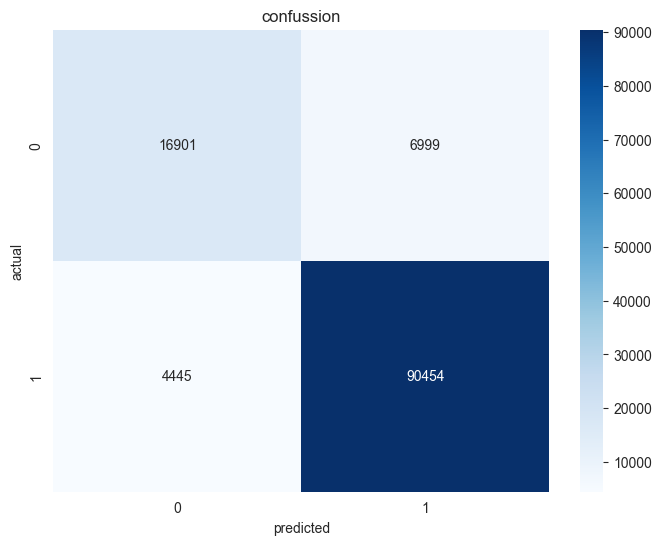

In [29]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_fsp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## RESIDUAL MODEL

In [30]:
train_fsp = pd.read_csv(os.path.join(DIR, 'sub\\resample\\train_fsp.csv'), index_col='id')
resid = train[TARGET] - train_fsp[TARGET]

In [48]:
cv = 5
resid_feas_select = []

In [49]:
resid_feas_select.append(('RAW', xgg_feature_test(train[COL], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[200]	train-rmse:0.20531	valid-rmse:0.21328
FOLD 1 RMSE: 0.04549

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20566	valid-rmse:0.21220
FOLD 2 RMSE: 0.04504

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[199]	train-rmse:0.20618	valid-rmse:0.21121
FOLD 3 RMSE: 0.04462

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[200]	train-rmse:0.20521	valid-rmse:0.21397
FOLD 4 RMSE: 0.04579

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23564
[199]	train-rmse:0.19990	valid-rmse:0.23718
FOLD 5 RMSE: 0.05626

MEAN RMSE: 0.04744


In [50]:
resid_feas_select.append(('FREQ', xgg_feature_test(train[COL+FREQ], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21499	valid-rmse:0.21062
[199]	train-rmse:0.20156	valid-rmse:0.21347
FOLD 1 RMSE: 0.04558

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21532	valid-rmse:0.20932
[199]	train-rmse:0.20196	valid-rmse:0.21292
FOLD 2 RMSE: 0.04534

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21554	valid-rmse:0.20844
[200]	train-rmse:0.20224	valid-rmse:0.21113
FOLD 3 RMSE: 0.04458

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21494	valid-rmse:0.21089
[200]	train-rmse:0.20170	valid-rmse:0.21452
FOLD 4 RMSE: 0.04602

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20925	valid-rmse:0.23564
[199]	train-rmse:0.19842	valid-rmse:0.23730
FOLD 5 RMSE: 0.05631

MEAN RMSE: 0.04757


In [51]:
resid_feas_select.append(('ORD', xgg_feature_test(train[COL+ORDCATE], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[199]	train-rmse:0.20533	valid-rmse:0.21328
FOLD 1 RMSE: 0.04549

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20566	valid-rmse:0.21220
FOLD 2 RMSE: 0.04504

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[199]	train-rmse:0.20618	valid-rmse:0.21121
FOLD 3 RMSE: 0.04462

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[199]	train-rmse:0.20523	valid-rmse:0.21395
FOLD 4 RMSE: 0.04578

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23564
[199]	train-rmse:0.19990	valid-rmse:0.23718
FOLD 5 RMSE: 0.05626

MEAN RMSE: 0.04744


In [52]:
resid_feas_select.append(('SUBGRADE', xgg_feature_test(train[COL+SUBGRADE], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[200]	train-rmse:0.20527	valid-rmse:0.21338
FOLD 1 RMSE: 0.04553

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20566	valid-rmse:0.21220
FOLD 2 RMSE: 0.04504

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[200]	train-rmse:0.20614	valid-rmse:0.21123
FOLD 3 RMSE: 0.04462

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[200]	train-rmse:0.20521	valid-rmse:0.21397
FOLD 4 RMSE: 0.04579

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23564
[199]	train-rmse:0.19990	valid-rmse:0.23718
FOLD 5 RMSE: 0.05626

MEAN RMSE: 0.04745


In [53]:
resid_feas_select.append(('TAR', xgg_feature_test(train[COL+TAR], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21276	valid-rmse:0.21047
[200]	train-rmse:0.19441	valid-rmse:0.22908
FOLD 1 RMSE: 0.05248

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21302	valid-rmse:0.21158
[199]	train-rmse:0.19466	valid-rmse:0.23606
FOLD 2 RMSE: 0.05573

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21330	valid-rmse:0.20813
[202]	train-rmse:0.19476	valid-rmse:0.22030
FOLD 3 RMSE: 0.04853

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21276	valid-rmse:0.21044
[202]	train-rmse:0.19371	valid-rmse:0.21372
FOLD 4 RMSE: 0.04567

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20916	valid-rmse:0.23592
[200]	train-rmse:0.19364	valid-rmse:0.24010
FOLD 5 RMSE: 0.05765

MEAN RMSE: 0.05201


In [54]:
resid_feas_select.append(('ROUND', xgg_feature_test(train[COL+ROUND], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[200]	train-rmse:0.20533	valid-rmse:0.21325
FOLD 1 RMSE: 0.04547

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20586	valid-rmse:0.21214
FOLD 2 RMSE: 0.04500

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[200]	train-rmse:0.20615	valid-rmse:0.21112
FOLD 3 RMSE: 0.04457

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[199]	train-rmse:0.20536	valid-rmse:0.21396
FOLD 4 RMSE: 0.04578

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23563
[200]	train-rmse:0.20002	valid-rmse:0.23740
FOLD 5 RMSE: 0.05637

MEAN RMSE: 0.04744


In [31]:
resid_param = tune_xgb_with_optuna(train[COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE], train[TARGET], train_fsp[TARGET], seed=SEED)

[I 2025-11-16 22:15:48,493] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.941277:  10%|█         | 1/10 [02:50<25:34, 170.53s/it, 170.52/900 seconds]

Trial 0: CV AUC = 0.94128
[I 2025-11-16 22:18:39,019] Trial 0 finished with value: 0.9412768045502773 and parameters: {'max_depth': 4, 'min_child_weight': 1.1400831896268993, 'subsample': 0.7917112673531447, 'colsample_bytree': 0.7609980508141433, 'reg_alpha': 0.1541613857145323, 'reg_lambda': 3.92145110114809, 'gamma': 2.6144387495341137, 'max_leaves': 29}. Best is trial 0 with value: 0.9412768045502773.


Best trial: 1. Best value: 0.941278:  20%|██        | 2/10 [05:40<22:41, 170.17s/it, 340.45/900 seconds]

Trial 1: CV AUC = 0.94128
[I 2025-11-16 22:21:28,944] Trial 1 finished with value: 0.9412776679765941 and parameters: {'max_depth': 6, 'min_child_weight': 6.981507268855532, 'subsample': 0.7240620696000307, 'colsample_bytree': 0.7389941162683585, 'reg_alpha': 0.2334906615287835, 'reg_lambda': 1.8854769494307855, 'gamma': 4.108544991748736, 'max_leaves': 16}. Best is trial 1 with value: 0.9412776679765941.


Best trial: 1. Best value: 0.941278:  30%|███       | 3/10 [09:40<23:34, 202.07s/it, 580.48/900 seconds]

Trial 2: CV AUC = 0.94128
[I 2025-11-16 22:25:28,971] Trial 2 finished with value: 0.941275751268331 and parameters: {'max_depth': 6, 'min_child_weight': 9.203103311558928, 'subsample': 0.8809898763202247, 'colsample_bytree': 0.8124043207688547, 'reg_alpha': 1.4278642112707665, 'reg_lambda': 3.145208264310715, 'gamma': 0.24111859845350359, 'max_leaves': 10}. Best is trial 1 with value: 0.9412776679765941.


Best trial: 1. Best value: 0.941278:  40%|████      | 4/10 [13:09<20:29, 204.85s/it, 789.58/900 seconds]

Trial 3: CV AUC = 0.94128
[I 2025-11-16 22:28:58,077] Trial 3 finished with value: 0.9412761981499129 and parameters: {'max_depth': 3, 'min_child_weight': 11.238489026690592, 'subsample': 0.8380056068435772, 'colsample_bytree': 0.9675027989818978, 'reg_alpha': 0.21300771659379514, 'reg_lambda': 1.6633429062738592, 'gamma': 0.25253006948468937, 'max_leaves': 29}. Best is trial 1 with value: 0.9412776679765941.


Best trial: 4. Best value: 0.941278:  50%|█████     | 5/10 [15:51<15:51, 190.33s/it, 951.64/900 seconds]

Trial 4: CV AUC = 0.94128
[I 2025-11-16 22:31:40,131] Trial 4 finished with value: 0.9412777074793791 and parameters: {'max_depth': 10, 'min_child_weight': 8.088248497768134, 'subsample': 0.6671068942597332, 'colsample_bytree': 0.9996631461030483, 'reg_alpha': 0.4217558350153665, 'reg_lambda': 0.7868085438617607, 'gamma': 4.225361994475714, 'max_leaves': 32}. Best is trial 4 with value: 0.9412777074793791.

Best trial summary:
  • Best AUC: 0.941278
  • Best parameters: {'max_depth': 10, 'min_child_weight': 8.088248497768134, 'subsample': 0.6671068942597332, 'colsample_bytree': 0.9996631461030483, 'reg_alpha': 0.4217558350153665, 'reg_lambda': 0.7868085438617607, 'gamma': 4.225361994475714, 'max_leaves': 32}


In [32]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\resample\\resid_param.json'), 'w') as f:
    json.dump(resid_param[0], f, indent=4)

In [33]:
# read the base model's predictions
pre_prev_train = pd.read_csv(os.path.join(DIR, 'sub\\resample\\train_fsp.csv'), index_col='id')
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\resample\\valid_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\resample\\test_fsp.csv'), index_col='id')
resid = train[TARGET] - pre_prev_train[TARGET]

with open(os.path.join(DIR, 'model\\resample\\resid_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    "learning_rate": 0.005,
    'seed': SEED,
})

cv=5
used_feas = COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_ssp = np.zeros(train.shape[0])
valid_ssp = np.zeros(valid.shape[0])
test_ssp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = resid.iloc[train_idx], resid.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=10000,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    valid_preds_proba = np.clip(valid_preds + pre_prev_train.iloc[valid_idx].values.flatten(), 0, 1)
    train_ssp[valid_idx] = valid_preds_proba
    test_ssp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_ssp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    y_true = train[TARGET].iloc[valid_idx]
    auc = roc_auc_score(y_true, valid_preds_proba)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds_proba > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_true, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_ssp = np.clip(test_ssp/cv + pre_prev_test.values.flatten(), 0, 1)
valid_ssp = np.clip(valid_ssp/cv + pre_prev_valid.values.flatten(), 0, 1)
# Save test data predictions
pd.DataFrame(data={'id': test.index, TARGET: test_ssp}).to_csv(os.path.join(DIR, 'sub\\resample\\test_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': train.index, TARGET: train_ssp}).to_csv(os.path.join(DIR, 'sub\\resample\\train_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_ssp}).to_csv(os.path.join(DIR, 'sub\\resample\\valid_ssp.csv'),index=False,header=True)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_ssp)} ACC = {accuracy_score(valid[TARGET], (valid_ssp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_ssp>0.5).astype(int))}')

1 auc = 0.94630 acc = 0.88598 f1 = 0.91722
2 auc = 0.94630 acc = 0.88523 f1 = 0.91683
3 auc = 0.94895 acc = 0.88779 f1 = 0.91877
4 auc = 0.94520 acc = 0.88469 f1 = 0.91606
5 auc = 0.91965 acc = 0.86804 f1 = 0.90574
BASE MODEL AUC = 0.94128 ACC = 0.88235 F1 = 0.91493.
BASE MODEL ON VALID DATA AUC = 0.9239185602345519 ACC = 0.9038039040732666 F1 = 0.9406288314872925


混淆矩阵:
[[16843  7057]
 [ 4371 90528]]


Text(0.5, 1.0, 'confussion')

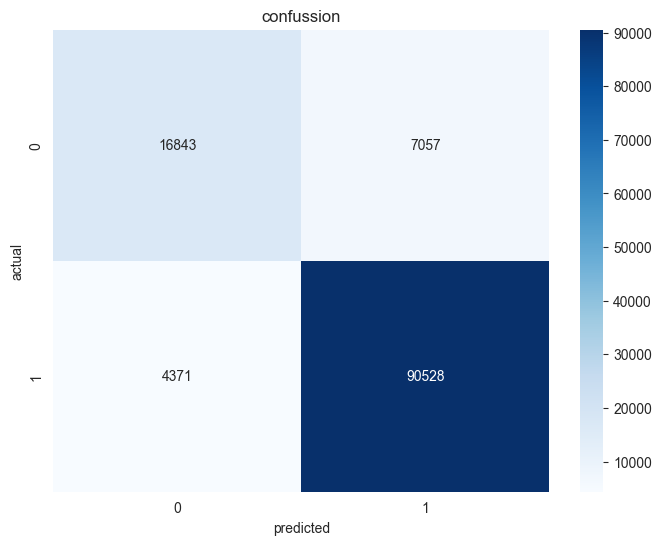

In [34]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_ssp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')